### Installations

*Attention:* 
Si vous utilisez un MacBook M1, veuillez vous référer à ce lien Stack Overflow pour obtenir des instructions sur l'installation de la bibliothèque cvxpy.
- https://stackoverflow.com/questions/73610748/how-to-install-cvxpy-on-mac-m1

In [5]:
%%capture
!pip install cvxpy pandas numpy

In [6]:
import cvxpy as cp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)

### Constantes

In [7]:
AUM = 1_000_000_000 # Actifs sous gestion de 1G USD

DEV_TITRES = 0.02 # Le poids actif de chaque titre doit être +-2%
DEV_SECTEUR = 0.05 # Le poids actif de chaque secteur doit être +-5%
DEV_BETA = 0.01 # Le béta du portefeuille par rapport à l'indice doit être entre 0.99 et 1.01
LIQUIDITE_PAR_TITRE = 1 # Le portefeuille ne doit pas détenir de titres à plus de 100% du volume quotidien
ROULEMENT = 0.1 # Le turnover du portefeuille doit être de moins de 10%
MIN_HOLDINGS_SIZE = 0.001 # Le poids minimal d'un titre est de 0.1%
MIN_NUMBER_HOLDINGS = 60 # Le portefeuille doit avoir au minimum 60 titres

N_ASSETS = 100 # Number of assets in random dataset

### Alignement des données et fonctions utilitaires

In [8]:
def generate_random_dataset():
    np.random.seed(1)
    n_assets = 100
    df_master = pd.DataFrame(
      data=np.arange(0, n_assets, 1).reshape(-1, 1),
        columns=['ticker'])
    df_master['alpha'] = np.random.randn(1, n_assets)[0]
    df_master['benchmark_weight'] = np.repeat(1 / n_assets, n_assets)
    df_master['initial_weight'] = np.repeat(1 / n_assets, n_assets)
    df_master['sector'] = ['Finance' for i in range(15)] + ['Consumer Discretionary' for i in range(25)] + ['Industrials' for i in range(15)] + ['Information Technology' for i in range(35)] + ['Energy' for i in range(10)]
    df_master['beta'] = np.random.normal(1, 0.5, n_assets)
    df_master['average_daily_volume_30d_dollar'] = abs(np.random.normal(30_000_000, 20_000_000, n_assets))
    df_master['average_daily_volume_30d_dollar'] = df_master['average_daily_volume_30d_dollar'].astype(int)
    df_master['average_daily_volume_30d_dollar_pct'] = df_master['average_daily_volume_30d_dollar'] / AUM
    return df_master

def produce_portfolio_metrics(portfolio_weights):
    df['final_weight'] = [round(z, 4) for z in portfolio_weights.value]
    df['in_portfolio'] = df['final_weight'] > 0.0
    df['active_weight'] = df['final_weight'] - df['benchmark_weight']
    df['trade_weight'] = df['final_weight'] - df['initial_weight']
    dict_metrics = {
    'Alpha': (df['final_weight'] * df['alpha']).sum(),
    'Transfer coefficient': np.corrcoef(df['alpha'], df['active_weight'])[0][1],
    'Total portfolio weight': df['final_weight'].sum(),
    'Maximum weight': df['final_weight'].max(),
    'Minimum weight': df['final_weight'].min(),
    'Beta': (df['final_weight'] * df['beta']).sum(),
    'Turnover': abs(df['final_weight'] - df['initial_weight']).sum() / 2,
    'Number of names': df['in_portfolio'].sum(),
    }
    return df.sort_values('final_weight', ascending=False), pd.DataFrame.from_dict(dict_metrics, orient='index')

def plot_output_graphs(df):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
    df.groupby('sector')['active_weight'].sum().sort_values(ascending=False).plot(kind='bar', ax=axes[0])
    df.sort_values(by='alpha', ascending=False)['active_weight'].plot(kind='bar', ax=axes[1])
    axes[0].set_title('Sector allocation')
    axes[1].set_title('Active weight per asset sorted by alpha')
    # add horizontal line at y=0
    axes[0].axhline(0, color='black')
    axes[1].axhline(0, color='black')
    plt.subplots_adjust(hspace = 1.0)
    plt.show()

In [9]:
df_master = generate_random_dataset()

In [10]:
df_master.sample(5)

,ticker,alpha,benchmark_weight,initial_weight,sector,beta,average_daily_volume_30d_dollar,average_daily_volume_30d_dollar_pct
46,46,0.190915,0.01,0.01,Industrials,1.038911,42370782,0.042371
35,35,-0.012665,0.01,0.01,Consumer Discretionary,0.688235,5337585,0.005338
6,6,1.744812,0.01,0.01,Finance,1.370278,3014425,0.003014
10,10,1.462108,0.01,0.01,Finance,0.313441,23470010,0.023470
60,60,-0.754398,0.01,0.01,Information Technology,0.741453,32124454,0.032124


### Fonction objectif

In [11]:
# generate variables and objective function
portfolio_weights = cp.Variable(N_ASSETS)
alpha = df_master['alpha'].tolist()
objective = cp.Maximize(cp.sum(alpha @ portfolio_weights))

### Contrainte 1: Stratégie long only

                               0
Alpha                   2.185575
Transfer coefficient    0.241279
Total portfolio weight  1.000000
Maximum weight          1.000000
Minimum weight         -0.000000
Beta                    2.095350
Turnover                0.990000
Number of names         1.000000


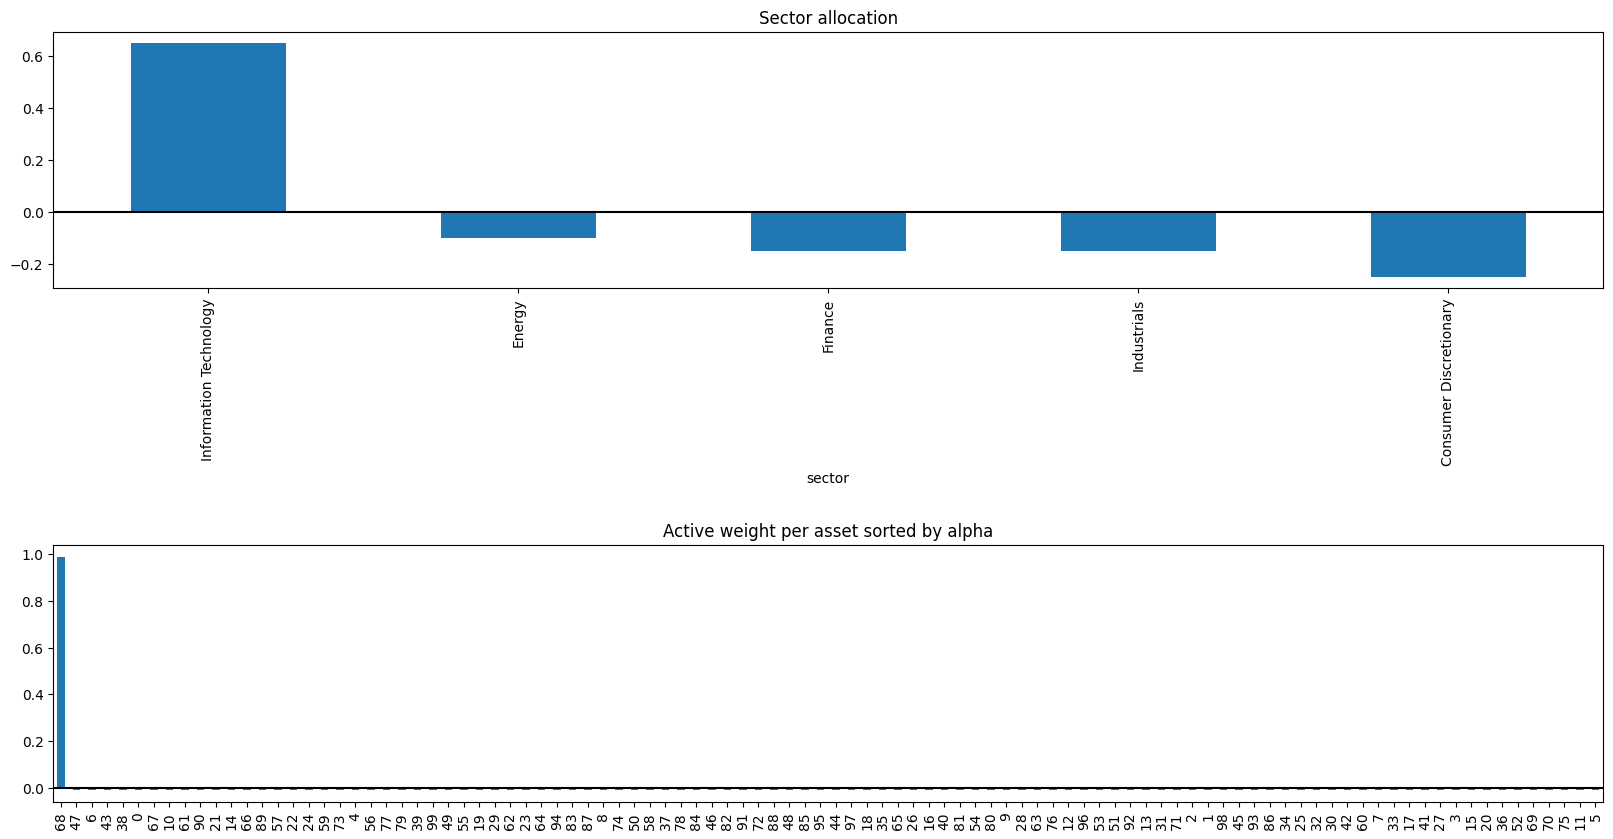

,ticker,alpha,benchmark_weight,initial_weight,sector,beta,average_daily_volume_30d_dollar,average_daily_volume_30d_dollar_pct,final_weight,in_portfolio,active_weight,trade_weight
58,58,0.285587,0.01,0.01,Information Technology,1.008705,38590522,0.038591,-0.0,False,-0.01,-0.01
48,48,0.120159,0.01,0.01,Industrials,1.116247,66210698,0.066211,-0.0,False,-0.01,-0.01
61,61,1.252868,0.01,0.01,Information Technology,0.501487,513606,0.000514,-0.0,False,-0.01,-0.01
44,44,0.050808,0.01,0.01,Industrials,1.264733,12773672,0.012774,-0.0,False,-0.01,-0.01
50,50,0.300170,0.01,0.01,Industrials,0.844942,23100255,0.023100,-0.0,False,-0.01,-0.01


In [12]:
df = df_master.copy()

# generate variables and objective function
portfolio_weights = cp.Variable(N_ASSETS)
in_portfolio = cp.Variable(N_ASSETS, boolean=True)  # bool representing if asset is in portfolio
alpha = df['alpha'].tolist()
beta = df['beta']
benchmark_weights = df['benchmark_weight']
initial_weights = df['initial_weight']
adv30_pct =  df['average_daily_volume_30d_dollar_pct']
objective = cp.Maximize(cp.sum(alpha @ portfolio_weights))

# long-only strategy constraints
constraints = [
    cp.sum(portfolio_weights) == 1, # fully funded
    portfolio_weights >= 0.0, # long only
    portfolio_weights <= 1.0, # max 100%
]

# solve for optimal portfolio
prob = cp.Problem(objective, constraints)
result = prob.solve(verbose=False, solver=cp.SCIPY) # change verbose to True if you have optimization problems

# produce portfolio outputs
df, dict_metrics = produce_portfolio_metrics(portfolio_weights)
print(dict_metrics)
plot_output_graphs(df)
df.sample(5)

### Contrainte 2: Déviation par titre

                                0
Alpha                    1.037730
Transfer coefficient     0.784526
Total portfolio weight   1.000000
Maximum weight           0.030000
Minimum weight          -0.000000
Beta                     1.104724
Turnover                 0.660000
Number of names         34.000000


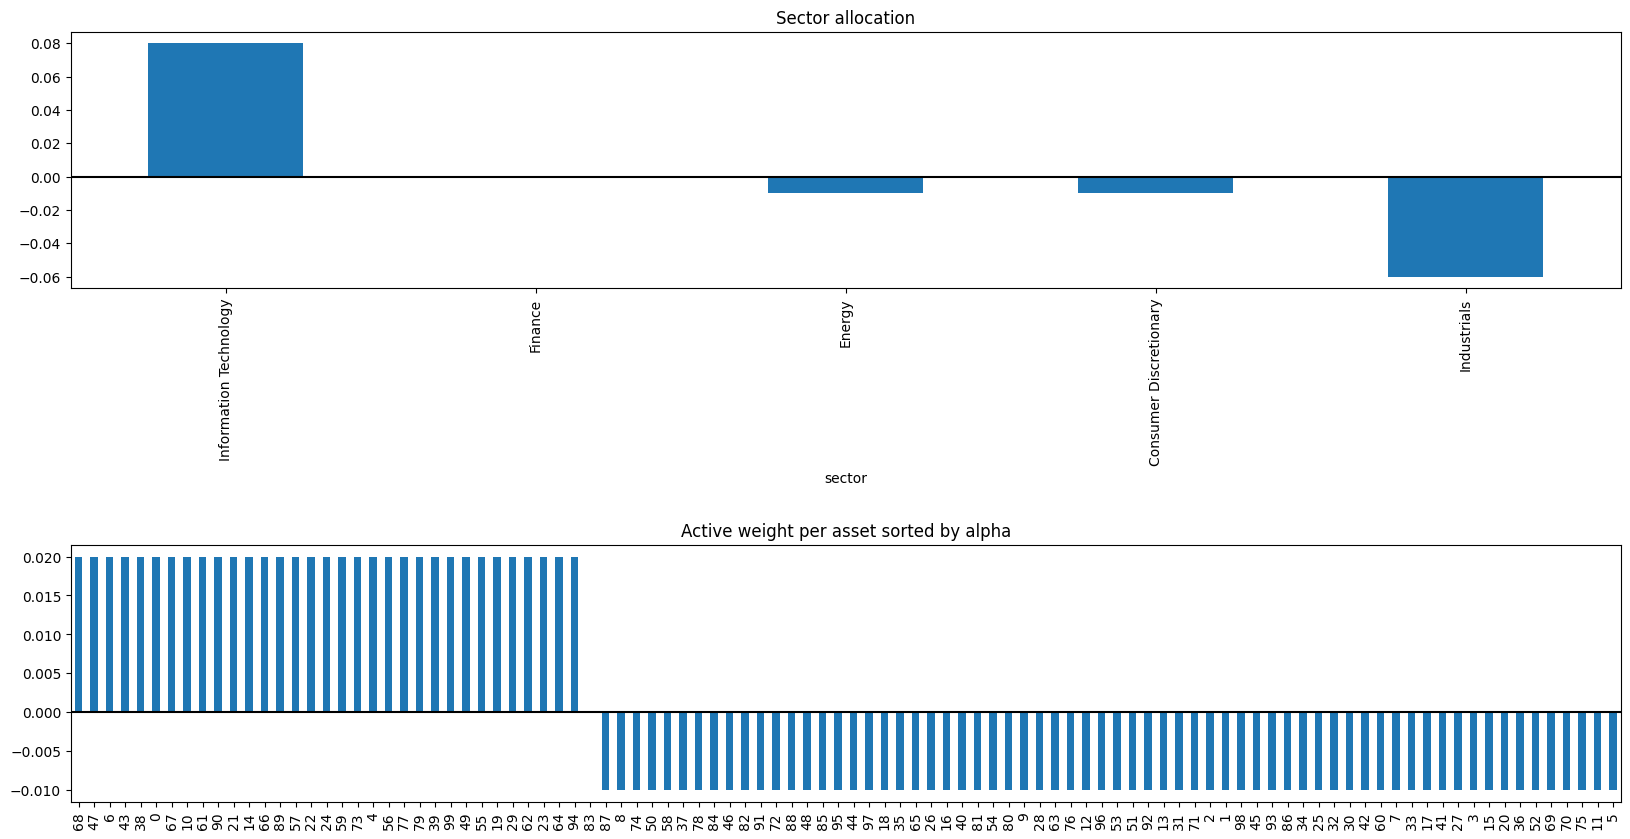

,ticker,alpha,benchmark_weight,initial_weight,sector,beta,average_daily_volume_30d_dollar,average_daily_volume_30d_dollar_pct,final_weight,in_portfolio,active_weight,trade_weight
48,48,0.120159,0.01,0.01,Industrials,1.116247,66210698,0.066211,-0.00,False,-0.01,-0.01
59,59,0.885141,0.01,0.01,Information Technology,0.438991,17860032,0.017860,0.03,True,0.02,0.02
40,40,-0.191836,0.01,0.01,Industrials,0.906715,20035728,0.020036,-0.00,False,-0.01,-0.01
8,8,0.319039,0.01,0.01,Finance,0.866891,7617692,0.007618,-0.00,False,-0.01,-0.01
78,78,0.230095,0.01,0.01,Information Technology,1.340035,24916402,0.024916,-0.00,False,-0.01,-0.01


In [13]:
df = df_master.copy()

# generate variables and objective function
portfolio_weights = cp.Variable(N_ASSETS)
in_portfolio = cp.Variable(N_ASSETS, boolean=True)  # bool representing if asset is in portfolio
alpha = df['alpha'].tolist()
beta = df['beta']
benchmark_weights = df['benchmark_weight']
initial_weights = df['initial_weight']
adv30_pct =  df['average_daily_volume_30d_dollar_pct']
objective = cp.Maximize(cp.sum(alpha @ portfolio_weights))

# long-only strategy constraints
constraints = [
    cp.sum(portfolio_weights) == 1, # fully funded
    portfolio_weights >= 0.0, # long only
    portfolio_weights <= 1.0, # max 100%
    cp.abs(portfolio_weights - benchmark_weights) <= DEV_TITRES, # deviation par titre
]

# solve for optimal portfolio
prob = cp.Problem(objective, constraints)
result = prob.solve(verbose=False, solver=cp.SCIPY) # change verbose to True if you have optimization problems

# produce portfolio outputs
df, dict_metrics = produce_portfolio_metrics(portfolio_weights)
print(dict_metrics)
plot_output_graphs(df)
df.sample(5)

### Contrainte 3: Allocation sectorielle

                                0
Alpha                    1.033241
Transfer coefficient     0.788932
Total portfolio weight   1.000000
Maximum weight           0.030000
Minimum weight          -0.000000
Beta                     1.089093
Turnover                 0.650000
Number of names         35.000000


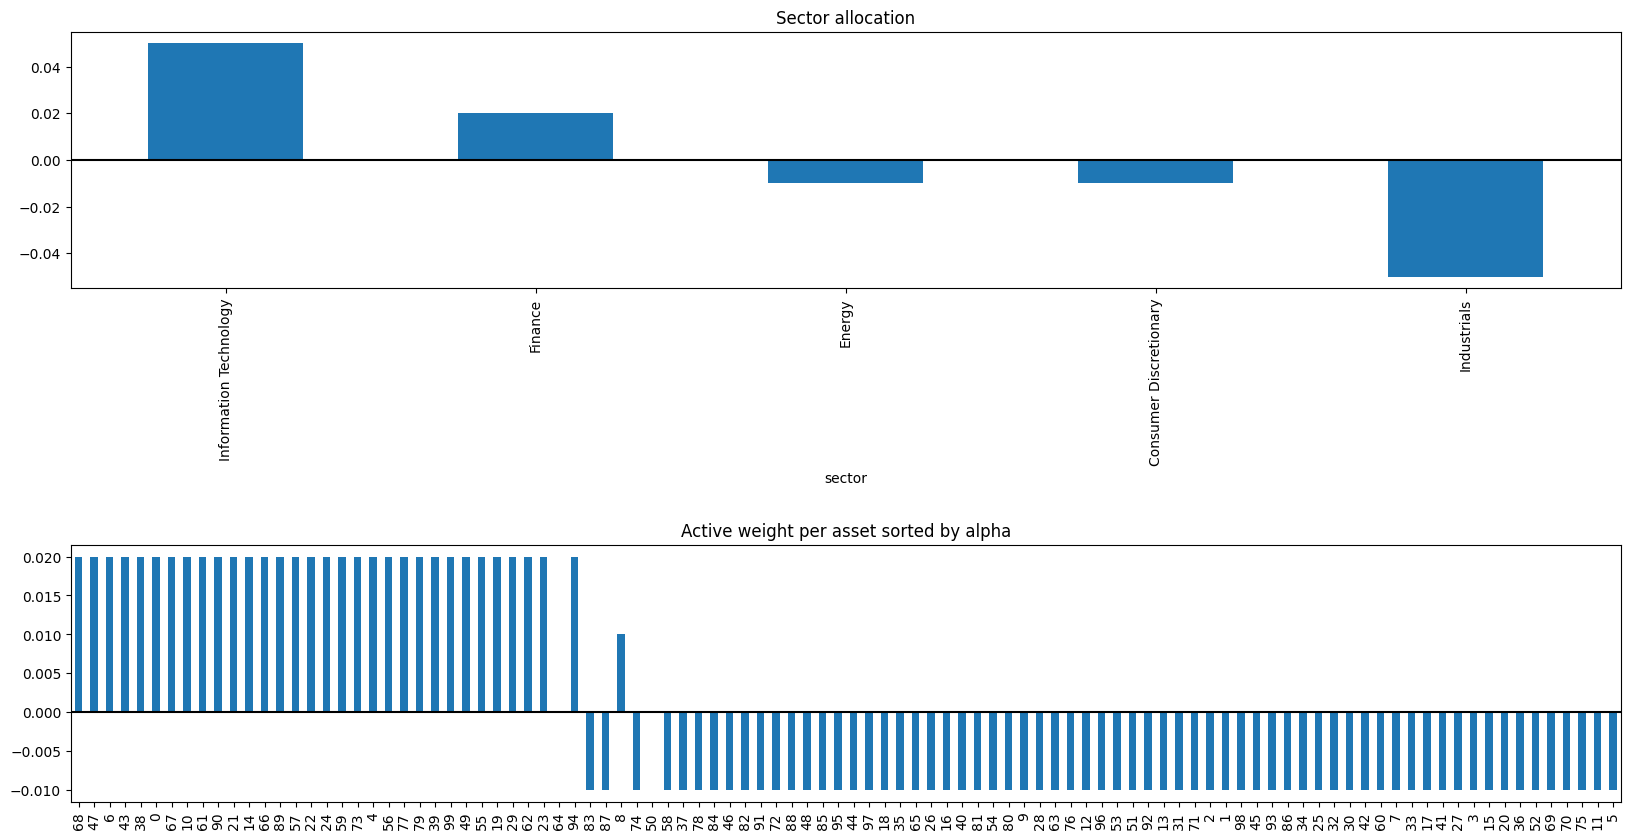

,ticker,alpha,benchmark_weight,initial_weight,sector,beta,average_daily_volume_30d_dollar,average_daily_volume_30d_dollar_pct,final_weight,in_portfolio,active_weight,trade_weight
89,89,1.129484,0.01,0.01,Information Technology,0.963444,31618542,0.031619,0.03,True,0.02,0.02
74,74,0.315635,0.01,0.01,Information Technology,1.021834,12454369,0.012454,-0.00,False,-0.01,-0.01
71,71,-0.504466,0.01,0.01,Information Technology,1.450743,60867182,0.060867,-0.00,False,-0.01,-0.01
11,11,-2.060141,0.01,0.01,Finance,1.157580,3146484,0.003146,-0.00,False,-0.01,-0.01
90,90,1.198918,0.01,0.01,Energy,1.580169,26268420,0.026268,0.03,True,0.02,0.02


In [14]:
df = df_master.copy()

# generate variables and objective function
portfolio_weights = cp.Variable(N_ASSETS)
in_portfolio = cp.Variable(N_ASSETS, boolean=True)  # bool representing if asset is in portfolio
alpha = df['alpha'].tolist()
beta = df['beta']
benchmark_weights = df['benchmark_weight']
initial_weights = df['initial_weight']
adv30_pct =  df['average_daily_volume_30d_dollar_pct']
objective = cp.Maximize(cp.sum(alpha @ portfolio_weights))

# long-only strategy constraints
constraints = [
    cp.sum(portfolio_weights) == 1, # fully funded
    portfolio_weights >= 0.0, # long only
    portfolio_weights <= 1.0, # max 100%
    cp.abs(portfolio_weights - benchmark_weights) <= DEV_TITRES, # deviation par titre
]

# Sector allocation constraints
# Group the dataframe by 'sector'
grouped = df.groupby('sector')
# For each group (i.e., sector), add a constraint
for sector, group in grouped:
    mask = df['sector'] == sector
    constraints.append(cp.abs(cp.sum(portfolio_weights[mask] - benchmark_weights[mask])) <= DEV_SECTEUR)

# solve for optimal portfolio
prob = cp.Problem(objective, constraints)
result = prob.solve(verbose=False, solver=cp.SCIPY) # change verbose to True if you have optimization problems

# produce portfolio outputs
df, dict_metrics = produce_portfolio_metrics(portfolio_weights)
print(dict_metrics)
plot_output_graphs(df)
df.sample(5)

### Contrainte 3: Contrôle du béta

                                0
Alpha                    1.015491
Transfer coefficient     0.775341
Total portfolio weight   1.000000
Maximum weight           0.030000
Minimum weight          -0.000000
Beta                     1.010030
Turnover                 0.650000
Number of names         35.000000


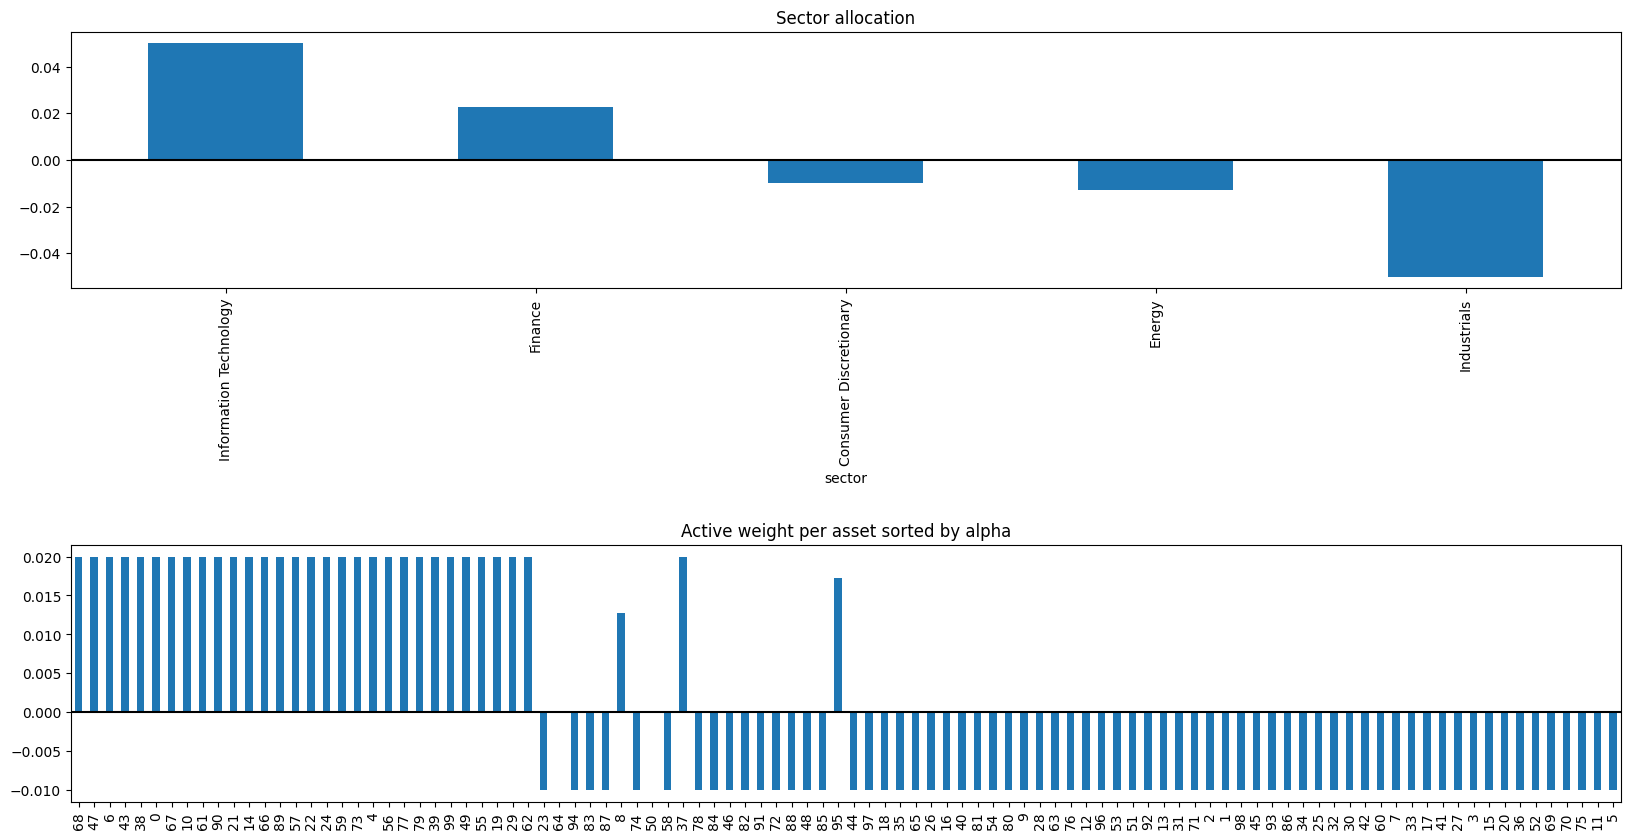

,ticker,alpha,benchmark_weight,initial_weight,sector,beta,average_daily_volume_30d_dollar,average_daily_volume_30d_dollar_pct,final_weight,in_portfolio,active_weight,trade_weight
21,21,1.144724,0.01,0.01,Consumer Discretionary,0.612419,40054817,0.040055,0.03,True,0.02,0.02
32,32,-0.687173,0.01,0.01,Consumer Discretionary,0.384971,43220405,0.043220,-0.00,False,-0.01,-0.01
9,9,-0.249370,0.01,0.01,Finance,1.016307,69121578,0.069122,-0.00,False,-0.01,-0.01
42,42,-0.747158,0.01,0.01,Industrials,1.434443,29962170,0.029962,-0.00,False,-0.01,-0.01
13,13,-0.384054,0.01,0.01,Finance,0.570242,18269521,0.018270,-0.00,False,-0.01,-0.01


In [15]:
df = df_master.copy()

# generate variables and objective function
portfolio_weights = cp.Variable(N_ASSETS)
in_portfolio = cp.Variable(N_ASSETS, boolean=True)  # bool representing if asset is in portfolio
alpha = df['alpha'].tolist()
beta = df['beta']
benchmark_weights = df['benchmark_weight']
initial_weights = df['initial_weight']
adv30_pct =  df['average_daily_volume_30d_dollar_pct']
objective = cp.Maximize(cp.sum(alpha @ portfolio_weights))

# long-only strategy constraints
constraints = [
    cp.sum(portfolio_weights) == 1, # fully funded
    portfolio_weights >= 0.0, # long only
    portfolio_weights <= 1.0, # max 100%
    cp.abs(portfolio_weights - benchmark_weights) <= DEV_TITRES, # deviation par titre
    cp.abs(cp.sum(portfolio_weights @ beta - 1.0)) <= DEV_BETA, # deviation beta
]

# Sector allocation constraints
# Group the dataframe by 'sector'
grouped = df.groupby('sector')
# For each group (i.e., sector), add a constraint
for sector, group in grouped:
    mask = df['sector'] == sector
    constraints.append(cp.abs(cp.sum(portfolio_weights[mask] - benchmark_weights[mask])) <= DEV_SECTEUR)

# solve for optimal portfolio
prob = cp.Problem(objective, constraints)
result = prob.solve(verbose=False, solver=cp.SCIPY) # change verbose to True if you have optimization problems

# produce portfolio outputs
df, dict_metrics = produce_portfolio_metrics(portfolio_weights)
print(dict_metrics)
plot_output_graphs(df)
df.sample(5)

### Contrainte 4: Contrôle de la liquidité

                                0
Alpha                    0.697455
Transfer coefficient     0.576108
Total portfolio weight   1.000300
Maximum weight           0.030000
Minimum weight          -0.000000
Beta                     1.010154
Turnover                 0.572150
Number of names         52.000000


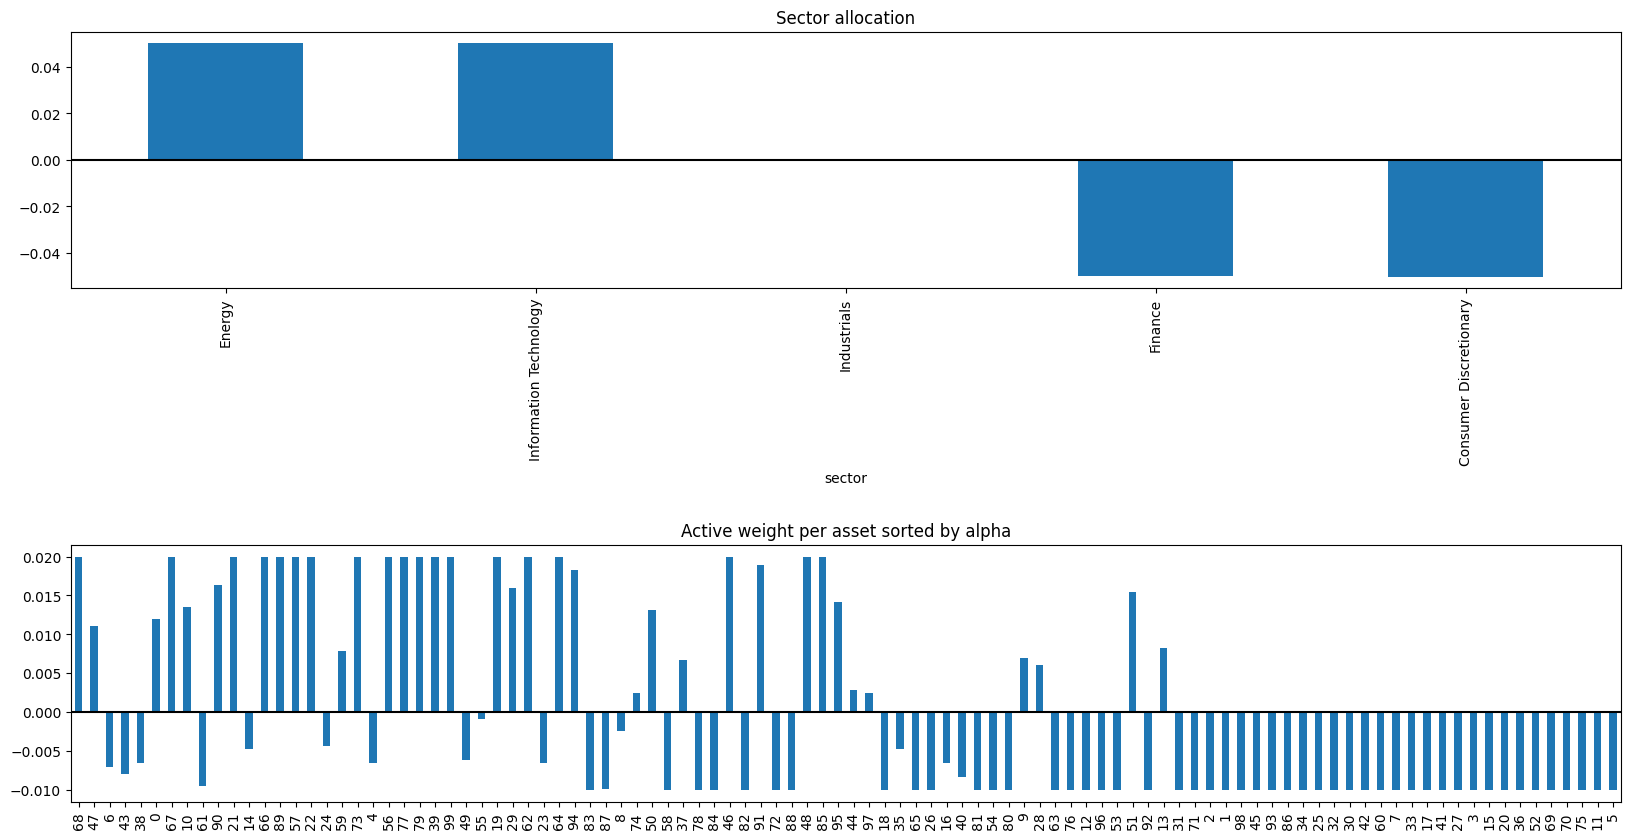

,ticker,alpha,benchmark_weight,initial_weight,sector,beta,average_daily_volume_30d_dollar,average_daily_volume_30d_dollar_pct,final_weight,in_portfolio,active_weight,trade_weight
24,24,0.900856,0.01,0.01,Consumer Discretionary,0.071009,5605112,0.005605,0.0056,True,-0.0044,-0.0044
95,95,0.077340,0.01,0.01,Energy,0.186281,24052762,0.024053,0.0241,True,0.0141,0.0141
79,79,0.762011,0.01,0.01,Information Technology,0.840099,57996878,0.057997,0.0300,True,0.0200,0.0200
67,67,1.519817,0.01,0.01,Information Technology,1.106767,35249348,0.035249,0.0300,True,0.0200,0.0200
48,48,0.120159,0.01,0.01,Industrials,1.116247,66210698,0.066211,0.0300,True,0.0200,0.0200


In [16]:
df = df_master.copy()

# generate variables and objective function
portfolio_weights = cp.Variable(N_ASSETS)
in_portfolio = cp.Variable(N_ASSETS, boolean=True)  # bool representing if asset is in portfolio
alpha = df['alpha'].tolist()
beta = df['beta']
benchmark_weights = df['benchmark_weight']
initial_weights = df['initial_weight']
adv30_pct =  df['average_daily_volume_30d_dollar_pct']
objective = cp.Maximize(cp.sum(alpha @ portfolio_weights))

# long-only strategy constraints
constraints = [
    cp.sum(portfolio_weights) == 1, # fully funded
    portfolio_weights >= 0.0, # long only
    portfolio_weights <= 1.0, # max 100%
    cp.abs(portfolio_weights - benchmark_weights) <= DEV_TITRES, # deviation par titre
    cp.abs(cp.sum(portfolio_weights @ beta - 1.0)) <= DEV_BETA, # deviation beta
    portfolio_weights <= LIQUIDITE_PAR_TITRE * adv30_pct, # limite de liquidite
]

# Sector allocation constraints
# Group the dataframe by 'sector'
grouped = df.groupby('sector')
# For each group (i.e., sector), add a constraint
for sector, group in grouped:
    mask = df['sector'] == sector
    constraints.append(cp.abs(cp.sum(portfolio_weights[mask] - benchmark_weights[mask])) <= DEV_SECTEUR)

# solve for optimal portfolio
prob = cp.Problem(objective, constraints)
result = prob.solve(verbose=False, solver=cp.SCIPY) # change verbose to True if you have optimization problems

# produce portfolio outputs
df, dict_metrics = produce_portfolio_metrics(portfolio_weights)
print(dict_metrics)
plot_output_graphs(df)
df.sample(5)

### Contrainte 5: Limite du taux de roulement

                                0
Alpha                    0.697455
Transfer coefficient     0.576108
Total portfolio weight   1.000300
Maximum weight           0.030000
Minimum weight          -0.000000
Beta                     1.010154
Turnover                 0.572150
Number of names         52.000000


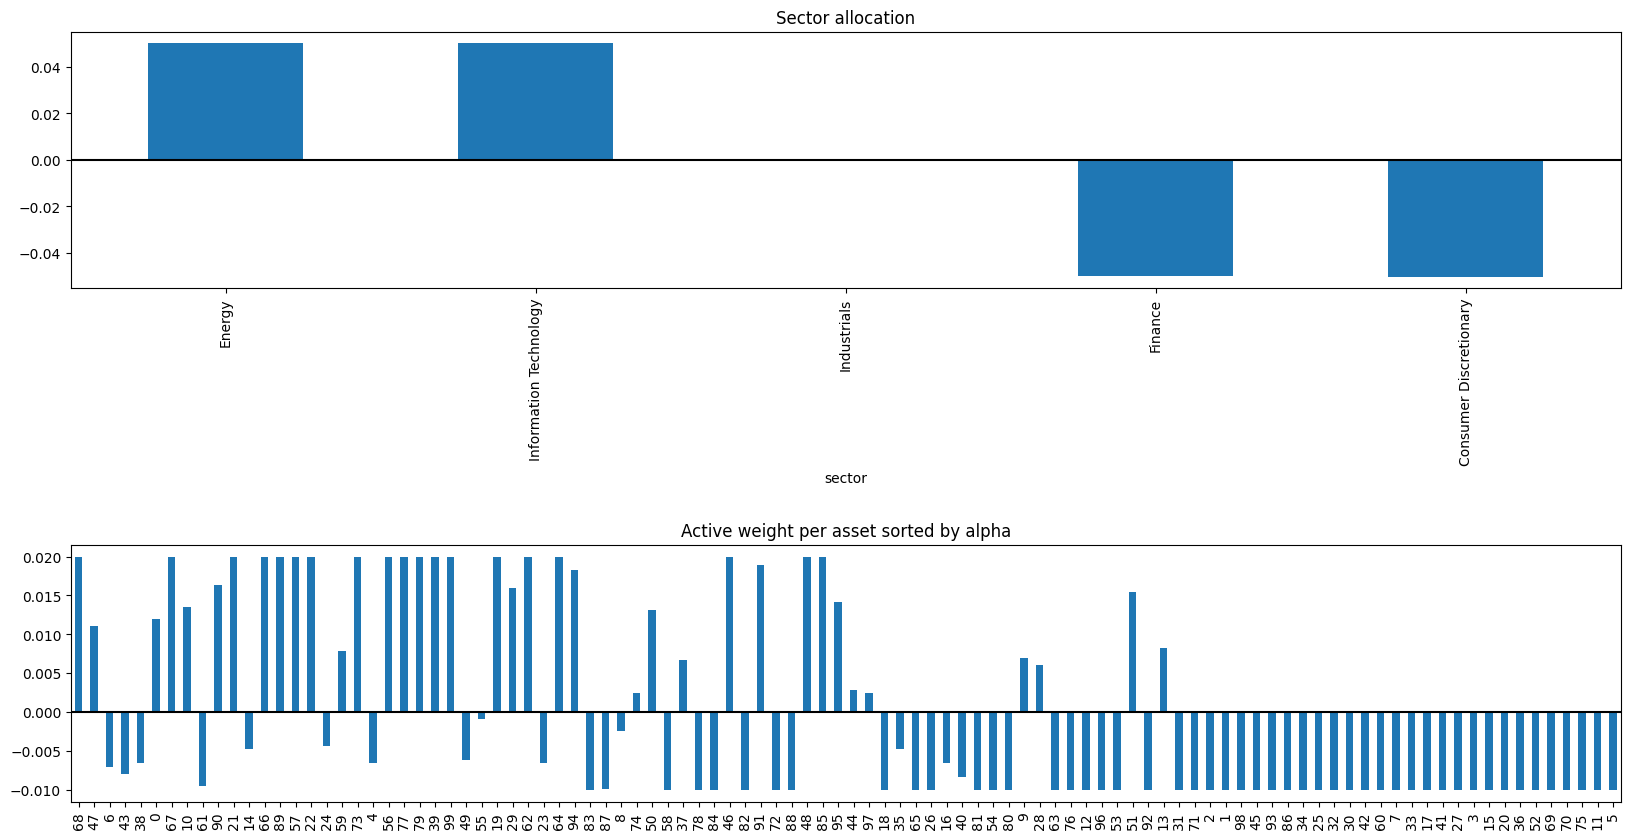

,ticker,alpha,benchmark_weight,initial_weight,sector,beta,average_daily_volume_30d_dollar,average_daily_volume_30d_dollar_pct,final_weight,in_portfolio,active_weight,trade_weight
43,43,1.692455,0.01,0.01,Industrials,1.375206,2067591,0.002068,0.0021,True,-0.0079,-0.0079
37,37,0.234416,0.01,0.01,Consumer Discretionary,0.427829,16684909,0.016685,0.0167,True,0.0067,0.0067
21,21,1.144724,0.01,0.01,Consumer Discretionary,0.612419,40054817,0.040055,0.0300,True,0.0200,0.0200
20,20,-1.100619,0.01,0.01,Consumer Discretionary,0.987692,62338991,0.062339,-0.0000,False,-0.0100,-0.0100
66,66,1.131629,0.01,0.01,Information Technology,1.493168,35694962,0.035695,0.0300,True,0.0200,0.0200


In [17]:
df = df_master.copy()

# generate variables and objective function
portfolio_weights = cp.Variable(N_ASSETS)
in_portfolio = cp.Variable(N_ASSETS, boolean=True)  # bool representing if asset is in portfolio
alpha = df['alpha'].tolist()
beta = df['beta']
benchmark_weights = df['benchmark_weight']
initial_weights = df['initial_weight']
adv30_pct =  df['average_daily_volume_30d_dollar_pct']
objective = cp.Maximize(cp.sum(alpha @ portfolio_weights))

# long-only strategy constraints
constraints = [
    cp.sum(portfolio_weights) == 1, # fully funded
    portfolio_weights >= 0.0, # long only
    portfolio_weights <= 1.0, # max 100%
    cp.abs(portfolio_weights - benchmark_weights) <= DEV_TITRES, # deviation par titre
    cp.abs(cp.sum(portfolio_weights @ beta - 1.0)) <= DEV_BETA, # deviation beta
    portfolio_weights <= LIQUIDITE_PAR_TITRE * adv30_pct, # limite de liquidite
    # cp.sum(cp.abs(portfolio_weights - initial_weights)) / 2 <= ROULEMENT, # limite de turnover
]

# Sector allocation constraints
# Group the dataframe by 'sector'
grouped = df.groupby('sector')
# For each group (i.e., sector), add a constraint
for sector, group in grouped:
    mask = df['sector'] == sector
    constraints.append(cp.abs(cp.sum(portfolio_weights[mask] - benchmark_weights[mask])) <= DEV_SECTEUR)

# solve for optimal portfolio
prob = cp.Problem(objective, constraints)
result = prob.solve(verbose=False, solver=cp.SCIPY) # change verbose to True if you have optimization problems

# produce portfolio outputs
df, dict_metrics = produce_portfolio_metrics(portfolio_weights)
print(dict_metrics)
plot_output_graphs(df)
df.sample(5)

### Contrainte 6: Minimum en portefeuille et nombre de titres

                                0
Alpha                    0.695558
Transfer coefficient     0.577645
Total portfolio weight   1.000200
Maximum weight           0.030000
Minimum weight          -0.000000
Beta                     1.010079
Turnover                 0.565900
Number of names         60.000000


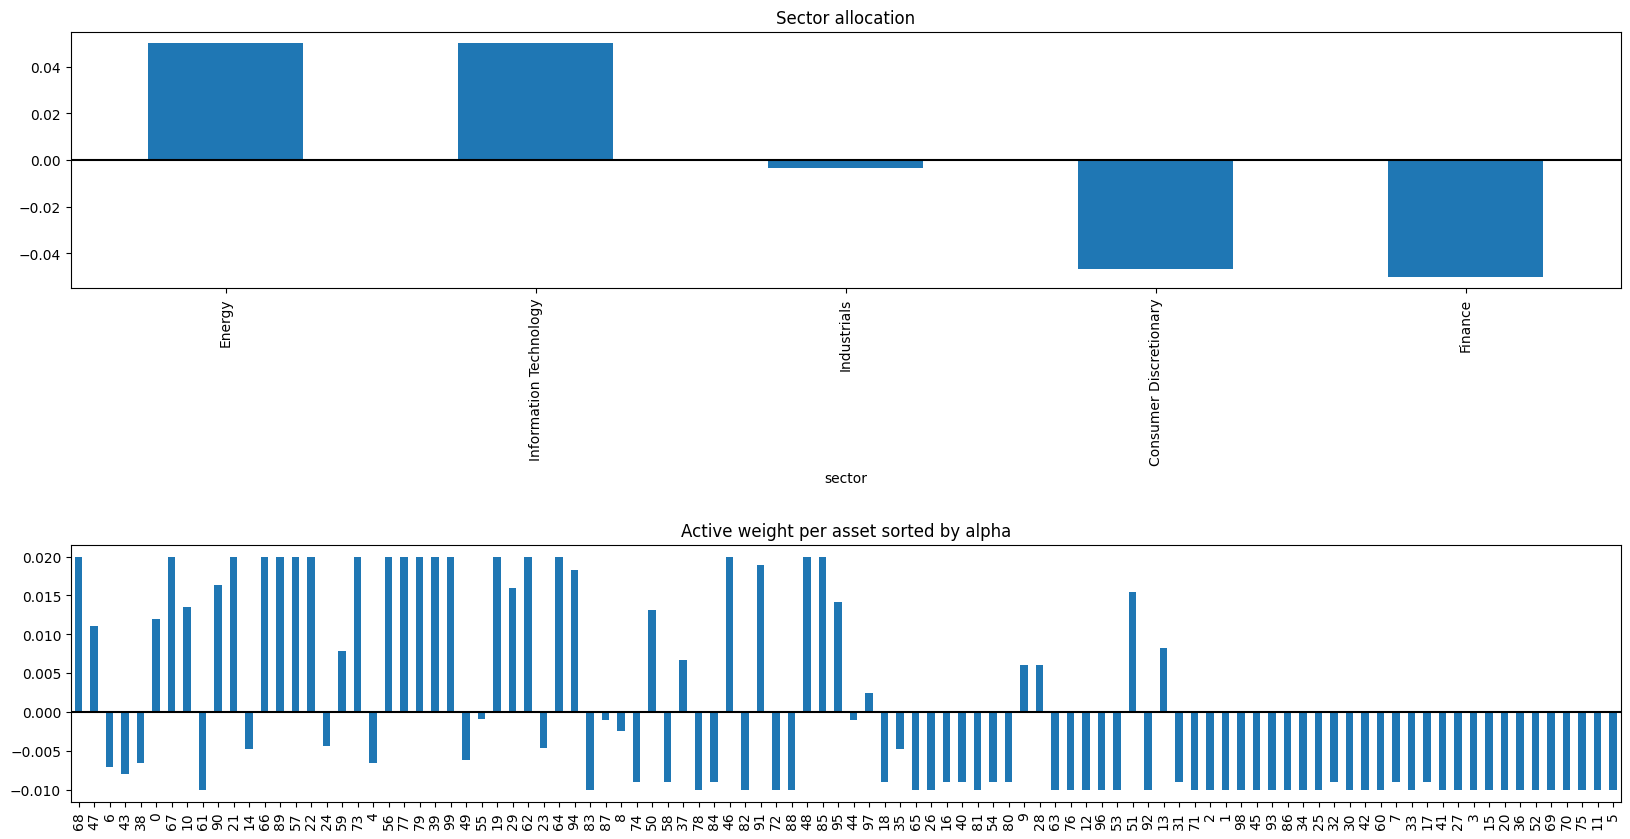

,ticker,alpha,benchmark_weight,initial_weight,sector,beta,average_daily_volume_30d_dollar,average_daily_volume_30d_dollar_pct,final_weight,in_portfolio,active_weight,trade_weight
25,25,-0.683728,0.01,0.01,Consumer Discretionary,1.618082,78987372,0.078987,-0.0000,False,-0.0100,-0.0100
49,49,0.617203,0.01,0.01,Industrials,1.341276,3885461,0.003885,0.0039,True,-0.0061,-0.0061
2,2,-0.528172,0.01,0.01,Finance,1.201746,18753891,0.018754,-0.0000,False,-0.0100,-0.0100
3,3,-1.072969,0.01,0.01,Finance,1.296789,69097561,0.069098,-0.0000,False,-0.0100,-0.0100
12,12,-0.322417,0.01,0.01,Finance,1.423080,52287659,0.052288,-0.0000,False,-0.0100,-0.0100


In [18]:
df = df_master.copy()

# generate variables and objective function
portfolio_weights = cp.Variable(N_ASSETS)
in_portfolio = cp.Variable(N_ASSETS, boolean=True)  # bool representing if asset is in portfolio
alpha = df['alpha'].tolist()
beta = df['beta']
benchmark_weights = df['benchmark_weight']
initial_weights = df['initial_weight']
adv30_pct =  df['average_daily_volume_30d_dollar_pct']
objective = cp.Maximize(cp.sum(alpha @ portfolio_weights))

# long-only strategy constraints
constraints = [
    cp.sum(portfolio_weights) == 1, # fully funded
    portfolio_weights >= 0.0, # long only
    portfolio_weights <= 1.0, # max 100%
    cp.abs(portfolio_weights - benchmark_weights) <= DEV_TITRES, # deviation par titre
    cp.abs(cp.sum(portfolio_weights @ beta - 1.0)) <= DEV_BETA, # deviation beta
    portfolio_weights <= LIQUIDITE_PAR_TITRE * adv30_pct, # limite de liquidite
    # cp.sum(cp.abs(portfolio_weights - initial_weights)) / 2 <= ROULEMENT, # limite de turnover
]

# Sector allocation constraints
# Group the dataframe by 'sector'
grouped = df.groupby('sector')
# For each group (i.e., sector), add a constraint
for sector, group in grouped:
    mask = df['sector'] == sector
    constraints.append(cp.abs(cp.sum(portfolio_weights[mask] - benchmark_weights[mask])) <= DEV_SECTEUR)

# Minimum holding size constraint and minimum number of names
eps = 1e-5
constraints += [
    -1 + eps <= portfolio_weights - in_portfolio,
    portfolio_weights - in_portfolio <= 0,
    portfolio_weights - in_portfolio >= MIN_HOLDINGS_SIZE - 1
]
constraints.append(cp.sum(in_portfolio) >= MIN_NUMBER_HOLDINGS)

# solve for optimal portfolio
prob = cp.Problem(objective, constraints)
result = prob.solve(verbose=False, solver=cp.SCIPY) # change verbose to True if you have optimization problems

# produce portfolio outputs
df, dict_metrics = produce_portfolio_metrics(portfolio_weights)
print(dict_metrics)
plot_output_graphs(df)
df.sample(5)